<a href="https://colab.research.google.com/github/CLCK0622/AI-prog/blob/main/main_0912.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Reference:
# Focal Loss: https://arxiv.org/abs/1708.02002v2
# U-Net: https://arxiv.org/abs/1505.04597

In [ ]:
!nvidia-smi

Wed Sep 11 05:18:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   39C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install scikit-learn -qq
!pip install rasterio -qq
!pip install geopandas -qq
!pip install GDAL -qq
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Colab Notebooks/ArcGIS"
%ls

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 70.0 MB/s eta 0:00:00
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ArcGIS
clipped_dem_ningxia_1000px.tif  combined_river_data.dbf  mosaicked_dem.tif
clipped_dem_ningxia_small.tif   combined_river_data.prj  normalized_clipped_dem_ningxia_small.tif
clipped_dem_ningxia.tif         combined_river_data.shp  normalized_dem.tif
CNN.drawio                      combined_river_data.shx  reprojected_dem_4490.tif
combined_dem.tif                Data/                    temp.tif
combined_river_data.cpg         main.ipynb


River Data Read!
EPSG:4490


流式输出内容被截断，只能显示最后 5000 行内容。


Boundary CRS:  EPSG:4490


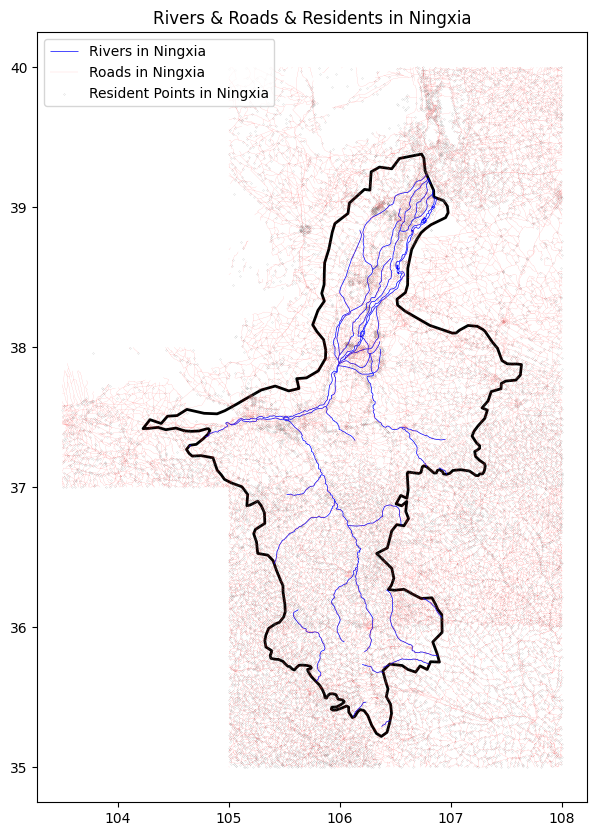

In [ ]:
import geopandas as gpd
import pandas as pd
from osgeo import gdal

gdal.SetConfigOption("SHAPE_ENCODING", "")

rivers_1 = gpd.read_file("Data/Rivers/River1.shp")
rivers_2 = gpd.read_file("Data/Rivers/River2.shp")
rivers_3 = gpd.read_file("Data/Rivers/River3.shp")
rivers_4 = gpd.read_file("Data/Rivers/River4.shp")
rivers_5 = gpd.read_file("Data/Rivers/River5.shp")
print("River Data Read!")

rivers_1['class'] = '1'
rivers_2['class'] = '2'
rivers_3['class'] = '3'
rivers_4['class'] = '4'
rivers_5['class'] = '5'

rivers_1.set_crs(epsg=4490, inplace=True, allow_override=True)
rivers_2.set_crs(epsg=4490, inplace=True, allow_override=True)
rivers_3.set_crs(epsg=4490, inplace=True, allow_override=True)
rivers_4.set_crs(epsg=4490, inplace=True, allow_override=True)
rivers_5.set_crs(epsg=4490, inplace=True, allow_override=True)

combined_river_data = gpd.GeoDataFrame(pd.concat([rivers_1, rivers_2, rivers_3, rivers_4, rivers_5], ignore_index=True))

print(combined_river_data.crs)
combined_river_data = combined_river_data.to_crs(epsg=4490)

combined_river_data = combined_river_data.drop_duplicates(subset=['geometry'], keep='first')

combined_river_data.to_file('combined_river_data.shp')

import matplotlib.pyplot as plt

province = gpd.read_file("Data/Provinces/map.shp")

ningxia_boundary = province[province['NAME'].str.contains('宁夏')]
ningxia_boundary = ningxia_boundary.to_crs(epsg=4490)

print("Boundary CRS: ", ningxia_boundary.crs)

combined_river_data = combined_river_data.to_crs(epsg=4490)

ningxia_rivers = gpd.clip(combined_river_data, ningxia_boundary)
# ningxia_rivers = combined_river_data

import os
parent_dir = 'Data/Roads'
directories = [os.path.join(dp, f) for dp, dn, filenames in os.walk(parent_dir) for f in filenames if f == 'lrdl.shp']
roads = []
for filepath in directories:
    data = gpd.read_file(filepath)
    roads.append(data)

combined_road_data = gpd.GeoDataFrame(pd.concat(roads, ignore_index=True))
combined_road_data = combined_road_data.to_crs(epsg=4490)

ningxia_roads = gpd.clip(combined_road_data, ningxia_boundary)
ningxia_roads = combined_road_data

parent_dir = 'Data/Roads'
directories = [os.path.join(dp, f) for dp, dn, filenames in os.walk(parent_dir) for f in filenames if f == 'resp.shp']
resid = []
for filepath in directories:
    data = gpd.read_file(filepath)
    resid.append(data)

combined_resid_data = gpd.GeoDataFrame(pd.concat(resid, ignore_index=True))
combined_resid_data = combined_resid_data.to_crs(epsg=4490)

ningxia_residents = gpd.clip(combined_resid_data, ningxia_boundary)
ningxia_residents = combined_resid_data

fig, ax = plt.subplots(figsize=(10, 10))
ningxia_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)  # Plot the '宁夏' boundary
ningxia_rivers.plot(ax=ax, color='blue', label='Rivers in Ningxia', linewidth=0.5)
ningxia_roads.plot(ax=ax, color='red', label='Roads in Ningxia', linewidth=0.05)
ningxia_residents.plot(ax=ax, color='grey', label='Resident Points in Ningxia', markersize=0.01)
plt.legend()
plt.title('Rivers & Roads & Residents in Ningxia')
plt.show()

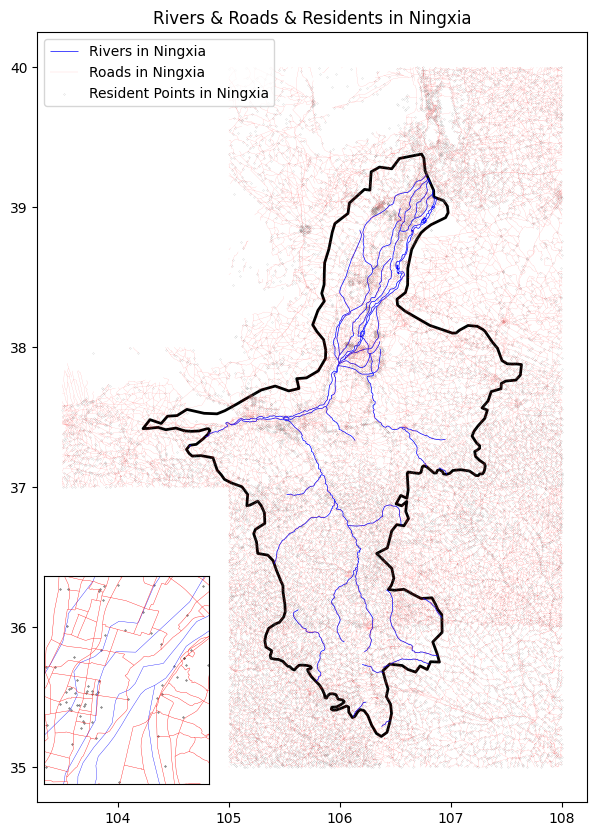

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(10, 10))
ningxia_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
ningxia_rivers.plot(ax=ax, color='blue', label='Rivers in Ningxia', linewidth=0.5)
ningxia_roads.plot(ax=ax, color='red', label='Roads in Ningxia', linewidth=0.05)
ningxia_residents.plot(ax=ax, color='grey', label='Resident Points in Ningxia', markersize=0.01)

plt.legend()
plt.title('Rivers & Roads & Residents in Ningxia')

ax_inset = inset_axes(ax, width="30%", height="30%", loc='lower left')

ningxia_rivers.plot(ax=ax_inset, color='blue', linewidth=0.25)
ningxia_roads.plot(ax=ax_inset, color='red', linewidth=0.25)
ningxia_residents.plot(ax=ax_inset, color='black', markersize=0.1)

ax_inset.set_xlim(106.2, 106.4)
ax_inset.set_ylim(38.2, 38.4)
ax_inset.set_xticks([])
ax_inset.set_yticks([])

plt.show()


In [ ]:
import rasterio
from rasterio.merge import merge
import glob
import os
import matplotlib.pyplot as plt

folder_path = 'Data/Height'
dem_files = glob.glob(os.path.join(folder_path, '*_dem.tif'))

dems = [rasterio.open(dem_file) for dem_file in dem_files]

if dems:
    mosaic, out_transform = merge(dems)
    out_meta = dems[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_transform,
        "dtype": rasterio.float32
    })

    with rasterio.open('mosaicked_dem.tif', 'w', **out_meta) as out_file:
        out_file.write(mosaic)
    print("Mosaic saved to 'mosaicked_dem.tif'.")
else:
    print("No DEM files were found or loaded.")

# with rasterio.open('mosaicked_dem.tif') as mosaic_raster:
#     mosaic_data = mosaic_raster.read(1)
#     plt.imshow(mosaic_data, cmap='terrain')
#     plt.colorbar(label='Elevation (m)')
#     plt.title('Mosaicked DEM')
#     plt.show()

for dem in dems:
    dem.close()

Mosaic saved to 'mosaicked_dem.tif'.


In [ ]:
from osgeo import gdal

input_file = 'mosaicked_dem.tif'
output_file = 'reprojected_dem_4490.tif'

warp_options = gdal.WarpOptions(dstSRS='EPSG:4490', format='GTiff', resampleAlg='near')  # 选择近邻插值
result = gdal.Warp(output_file, input_file, options=warp_options)

if result is None:
    print("Error: Re-projection failed.")
else:
    print("Re-projection completed successfully.")


Re-projection completed successfully.


In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt

with rasterio.open('reprojected_dem_4490.tif') as src:
    out_image, out_transform = mask(src, [ningxia_boundary.geometry.unary_union], crop=False, all_touched=True)

    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "nodata": src.nodata
    })

    with rasterio.open('clipped_dem_ningxia.tif', 'w', **out_meta) as out_raster:
        out_raster.write(out_image[0], 1)

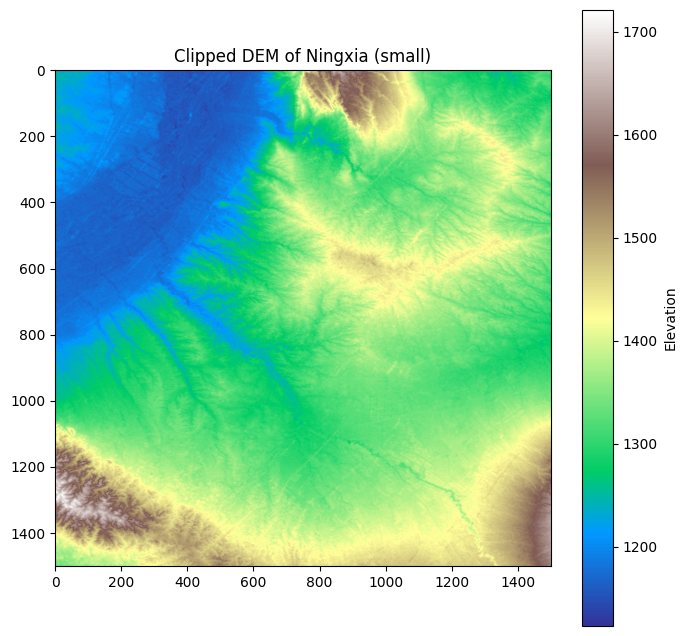

In [ ]:
import rasterio
from rasterio.windows import Window

def clip_center_of_raster(input_raster_path, output_raster_path, tile_size=1500):
    with rasterio.open(input_raster_path) as src:
        center_x, center_y = src.width // 2, src.height // 2

        window = Window(
            col_off=center_x - tile_size // 2,
            row_off=center_y - tile_size // 2,
            width=tile_size,
            height=tile_size
        )

        data = src.read(window=window)

        new_transform = src.window_transform(window)

        new_meta = src.meta.copy()
        new_meta.update({
            "driver": "GTiff",
            "height": tile_size,
            "width": tile_size,
            "transform": new_transform
        })

        with rasterio.open(output_raster_path, 'w', **new_meta) as dst:
            dst.write(data)

input_raster_path = 'reprojected_dem_4490.tif'
output_raster_path = 'clipped_dem_ningxia_small.tif'
clip_center_of_raster(input_raster_path, output_raster_path)

with rasterio.open('clipped_dem_ningxia_small.tif') as clipped_raster:
    clipped_data = clipped_raster.read(1, masked=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(clipped_data, cmap='terrain')
    plt.colorbar(label='Elevation')
    plt.title('Clipped DEM of Ningxia (small)')
    plt.show()


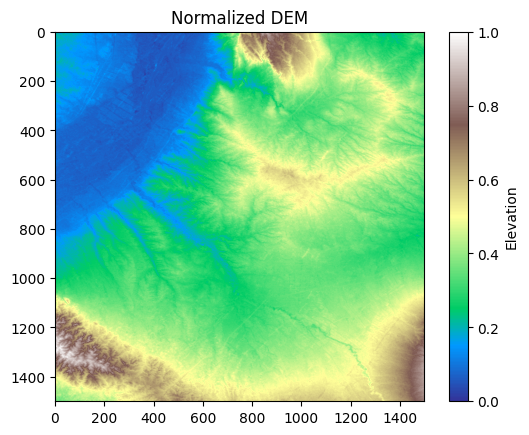

In [ ]:
import time
time.sleep(1)

from osgeo import gdal
import numpy as np

dataset = gdal.Open('clipped_dem_ningxia_small.tif', gdal.GA_ReadOnly)
band = dataset.GetRasterBand(1)
array = band.ReadAsArray()

min_val = np.min(array)
max_val = np.max(array)
array_normalized = (array - min_val) / (max_val - min_val)

driver = gdal.GetDriverByName('GTiff')
out_dataset = driver.Create('normalized_clipped_dem_ningxia_small.tif', dataset.RasterXSize, dataset.RasterYSize, 1, gdal.GDT_Float32)
out_band = out_dataset.GetRasterBand(1)
out_band.WriteArray(array_normalized)

out_dataset.SetGeoTransform(dataset.GetGeoTransform())
out_dataset.SetProjection(dataset.GetProjection())

out_band.FlushCache()
out_dataset = None

with rasterio.open('normalized_clipped_dem_ningxia_small.tif') as mosaic_raster:
    mosaic_data = mosaic_raster.read(1)
    plt.imshow(mosaic_data, cmap='terrain')
    plt.colorbar(label='Elevation')
    plt.title('Normalized DEM')
    plt.show()


In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np
import torch

height_tif = rasterio.open("normalized_clipped_dem_ningxia_small.tif")
height = height_tif.height
width = height_tif.width
print(f"height: {height}")
print(f"width: {width}")

def rasterize_shapefile(shapefile, reference_raster):
    transform = reference_raster.transform
    out_shape = (reference_raster.height, reference_raster.width)
    rasterized = rasterize([(geom, 1) for geom in shapefile.geometry],
                           out_shape=out_shape,
                           fill=0, transform=transform,
                           dtype='uint8')
    return rasterized

rivers_raster = rasterize_shapefile(ningxia_rivers, height_tif)
residents_raster = rasterize_shapefile(ningxia_residents, height_tif)
roads_raster = rasterize_shapefile(ningxia_roads, height_tif)

input_layers = np.stack([rivers_raster, residents_raster, height_tif.read(1)], axis=-1)

input_flat = input_layers.reshape(-1, input_layers.shape[2])

input_flat = input_layers
output_flat = roads_raster
print(input_flat.shape)

total_pixels = input_flat.shape[0]
train_size = int(total_pixels * 0.6)
val_size = int(total_pixels * 0.2)

indices = np.arange(total_pixels)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_x, train_y = input_flat[train_indices], output_flat[train_indices]
print(train_x.shape)
print(train_y.shape)
val_x, val_y = input_flat[val_indices], output_flat[val_indices]
test_x, test_y = input_flat[test_indices], output_flat[test_indices]

train_x, train_y = torch.from_numpy(train_x).permute(2, 0, 1).unsqueeze(0).float(), torch.from_numpy(train_y).unsqueeze(0).unsqueeze(0).float()
val_x, val_y = torch.from_numpy(val_x).permute(2, 0, 1).unsqueeze(0).float(), torch.from_numpy(val_y).unsqueeze(0).unsqueeze(0).float()
test_x, test_y = torch.from_numpy(test_x).permute(2, 0, 1).unsqueeze(0).float(), torch.from_numpy(test_y).unsqueeze(0).unsqueeze(0).float()
print(train_x.shape)
print(train_y.shape)
print(train_x.dtype)
print(train_y.dtype)

from torch.utils.data import TensorDataset, DataLoader

device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Now using {device} device!")

print("Shape of X_train before permute:", train_x.shape)
print("Shape of X_val before permute:", val_x.shape)
print("Shape of X_test before permute:", test_x.shape)

train_features = train_x
val_features = val_x
test_features = test_x

train_labels = train_y
val_labels = val_y
test_labels = test_y

train_features = train_features.to(device)
train_labels = train_labels.to(device)
val_features = val_features.to(device)
val_labels = val_labels.to(device)
test_features = test_features.to(device)
test_labels = test_labels.to(device)

train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)
test_dataset = TensorDataset(test_features, test_labels)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 0)

height: 1500
width: 1500
(1500, 1500, 3)
(900, 1500, 3)
(900, 1500)
torch.Size([1, 3, 900, 1500])
torch.Size([1, 1, 900, 1500])
torch.float32
torch.float32
Now using cuda device!
Shape of X_train before permute: torch.Size([1, 3, 900, 1500])
Shape of X_val before permute: torch.Size([1, 3, 300, 1500])
Shape of X_test before permute: torch.Size([1, 3, 300, 1500])


Loss: training 1.1400, validation 1.1690; Progress: 100%|██████████| 500/500 [04:41<00:00,  1.77it/s]

Training completed!


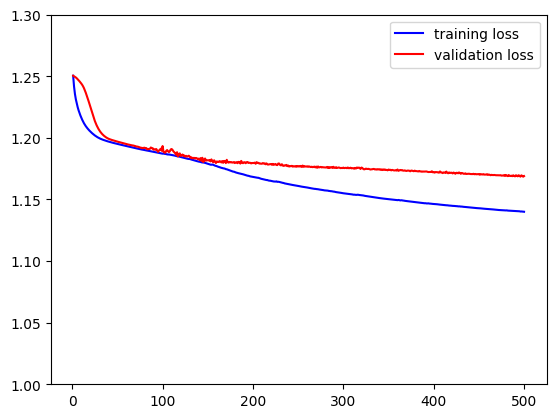

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

pos_weight = torch.tensor([30])

def connectivity_loss(mask, alpha = 0.05):
    kernel = torch.ones(5, 5).to(mask.device)
    dilated = F.conv2d(mask, kernel.unsqueeze(0).unsqueeze(0), padding=2)
    return torch.mean((dilated > 0).float() - mask) * alpha

def iou_loss(preds, labels, smooth=1e-6):
    preds = torch.sigmoid(preds)

    intersection = (preds * labels).sum(dim=[2, 3])
    union = (preds + labels).sum(dim=[2, 3]) - intersection

    iou = (intersection + smooth) / (union + smooth)

    return 1 - iou.mean()

class FocalLoss(nn.Module):
    def __init__(self, alpha = 0.1, gamma=3):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none', pos_weight=pos_weight.to(device))
        targets = targets.type(torch.float32)
        at = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        pt = torch.exp(-BCE_loss)
        F_loss = at * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return torch.sigmoid(self.conv(x))

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)

        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)

        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return logits


model = UNet(n_channels=3, n_classes=1).to(device)
criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay = 0.1)

training_loss_list = []
val_loss_list = []

def train():
    num_epochs = 500
    pbar = tqdm(range(num_epochs), desc="Loss: -- ; Progress")
    for epoch in pbar:
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            train_labels = labels
            optimizer.zero_grad()
            outputs = model(inputs)
            focal_loss_value = criterion(outputs, labels)
            connectivity_loss_value = connectivity_loss(outputs)
            iou_loss_value = iou_loss(outputs, labels)
            total_loss = focal_loss_value + connectivity_loss_value + iou_loss_value
            total_loss.backward()
            optimizer.step()
            train_loss += total_loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                focal_loss_value = criterion(outputs, labels)
                connectivity_loss_value = connectivity_loss(outputs)
                iou_loss_value = iou_loss(outputs, labels)
                total_loss = focal_loss_value + connectivity_loss_value + iou_loss_value
                val_loss += total_loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)

        if (epoch + 1) % 2 == 0:
            pbar.set_description(f"Loss: training {train_loss:.4f}, validation {val_loss:.4f}; Progress")
            # print(f'\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n')
        training_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

train()
print("Training completed!")

iter = []
for i in range(len(val_loss_list)):
    iter.append(i + 1)

plt.plot(iter, training_loss_list, color = 'blue', label = 'training loss')
plt.plot(iter, val_loss_list, color = 'red', label = 'validation loss')
plt.ylim(1, 1.3)
plt.legend()
plt.show()

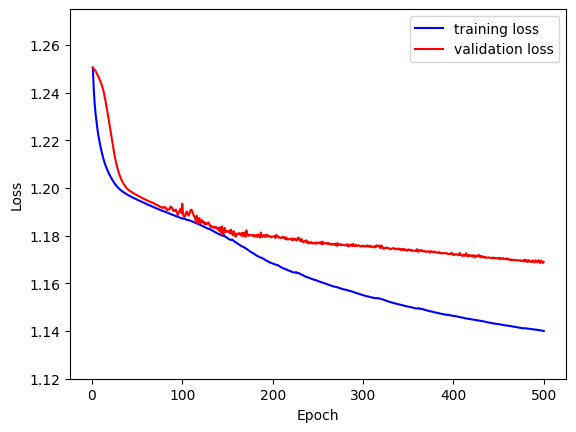

In [ ]:
plt.plot(iter, training_loss_list, color = 'blue', label = 'training loss')
plt.plot(iter, val_loss_list, color = 'red', label = 'validation loss')
plt.ylim(1.12, 1.275)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def tensor_to_numpy(outputs):
    if torch.is_tensor(outputs):
        outputs = outputs.detach()
    outputs_np = outputs.cpu().numpy()
    predicted_image = outputs_np[0, 0]
    predicted_image = (predicted_image > 0.5).astype(np.uint8)
    return predicted_image

def calculate_iou(predicted, target):
    intersection = np.logical_and(target, predicted)
    union = np.logical_or(target, predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def evaluate_model(model, dataloader, device):
    model.eval()
    ious = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            predicted_images = tensor_to_numpy(outputs)
            real_images = tensor_to_numpy(labels)

            iou_score = calculate_iou(predicted_images, real_images)
            ious.append(iou_score)

            plt.figure(figsize=(20, 10))
            plt.imshow(predicted_images, cmap='gray')
            plt.title('Predicted Road Map')
            plt.colorbar()

            plt.figure(figsize=(20, 10))
            plt.imshow(real_images, cmap='gray')
            plt.title('Real Road Map')
            plt.colorbar()
            plt.show()

    average_iou = np.mean(ious)
    print(f"Average IoU: {average_iou:.4f}")
    return average_iou

accuracy = evaluate_model(model, test_loader, device)
print(f'Accuracy on the test set: {accuracy*100:.2f}%')

accuracy = evaluate_model(model, val_loader, device)
print(f'Accuracy on the validation set: {accuracy*100:.2f}%')

accuracy = evaluate_model(model, train_loader, device)
print(f'Accuracy on the training set: {accuracy*100:.2f}%')


In [ ]:
import numpy as np

print("Shape of raster data:", roads_raster.shape)
print("Data type of raster data:", roads_raster.dtype)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(roads_raster, cmap='gray')
plt.colorbar()
plt.title('Visualization of Roads Raster')
plt.xlabel('Pixel X Coordinates')
plt.ylabel('Pixel Y Coordinates')
plt.show()


In [ ]:
# import gc
# del model
# gc.collect()
# torch.cuda.empty_cache()
# !nvidia-smi
# torch.cuda.device_count()
# print(torch.cuda.memory_allocated())
# print(torch.cuda.memory_reserved())

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import numpy as np
# from tqdm import tqdm

# # Define the U-Net-like model
# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2)
#         )

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 1, kernel_size=1)
#         )

#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         x = self.sigmoid(x)
#         return x

# # Initialize model, loss function, and optimizer
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = UNet().to(device)
# criterion = nn.BCELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1)

# training_loss_list = []
# val_loss_list = []

# # Training loop
# num_epochs = 100
# for epoch in tqdm(range(num_epochs)):
#     model.train()
#     train_loss = 0
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         train_labels = labels
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * inputs.size(0)
#     train_loss /= len(train_loader.dataset)

#     # Validation loop
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             # print(labels)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item() * inputs.size(0)
#     val_loss /= len(val_loader.dataset)

#     if (epoch + 1) % 10 == 0:
#         print(f'\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n')
#     training_loss_list.append(train_loss)
#     val_loss_list.append(val_loss)

# print("Training completed!")

# iter = []
# for i in range(len(val_loss_list)):
#     iter.append(i + 1)

# plt.plot(iter, training_loss_list, color = 'blue', label = 'training loss')
# plt.plot(iter, val_loss_list, color = 'red', label = 'validation loss')
# plt.ylim(0, 2)
# plt.legend()
# plt.show()